In [1]:
from RooPandasFunctions import PSequential,PColumn,PFilter,PRow,PProcessor,PProcRunner,PInitDir
import pandas as pd
from glob import glob
import ROOT
from ROOT import TH1F,TH2F,TLorentzVector,TFile,TCanvas,TLegend,gPad
from collections import OrderedDict
import numpy as np
import copy
import pyarrow as pa
import array
from optparse import OptionParser
import subprocess,os,sys
import time

Welcome to JupyROOT 6.22/00


In [2]:
op_nproc=int(6)
op_njet=int(3)
op_massrange="all"
op_aeval="95"
ntoys=0
quickrun=False
qcdonly=True
if quickrun:
    op_nproc=1

In [3]:
ROOT.gROOT.SetBatch(True)
ROOT.PyConfig.IgnoreCommandLineOptions = True

In [4]:
#this creates histos and  weights before any selection
class PreColumn():
    def __call__(self,df,EventInfo):
        EventInfo.eventcontainer["evweight"] = EventInfo.eventcontainer["lumi"]*EventInfo.eventcontainer["xsec"][EventInfo.dataset]/EventInfo.eventcontainer["nev"][EventInfo.dataset]
        df["Hists"]["logMSE_all"] = np.log(df["FatJet"]["iAEMSE"])
        df["Hists"]["weight"] *= EventInfo.eventcontainer["evweight"]
        df["Hists"]["logMSE_all__weight"] = pd.Series(EventInfo.eventcontainer["evweight"], df["Hists"]["logMSE_all"].index, name="logMSE_all__weight")
        return df

In [5]:
#Select jetwise and eventwise. Exactly 4 jets with pt in region X, and all have sdmass in region Y
class KinematicSelection():
    def __init__(self,njet,ptcut,msdcut,htcut):
        self.ptcut=ptcut
        self.njet=njet
        self.msdcut=msdcut
        self.htcut=htcut
    def __call__(self,df,EventInfo):
        
        fjcutpt=(df["FatJet"]["pt"]>self.ptcut[0]) & (df["FatJet"]["pt"]<self.ptcut[1]) 
        df["FatJet"]=df["FatJet"][fjcutpt]
        C0=(df["FatJet"]["event"].count(level=0))==self.njet
        
        fjcuteta=(df["FatJet"]["eta"].abs()>0.0) &(df["FatJet"]["eta"].abs()<2.0) 
        df["FatJet"]=df["FatJet"][fjcuteta]
        C1=(df["FatJet"]["event"].count(level=0))==self.njet

        fjcutmass=(df["FatJet"]["msoftdrop"]>self.msdcut[0])&(df["FatJet"]["msoftdrop"]<self.msdcut[1])
        df["FatJet"]=df["FatJet"][fjcutmass]
        C2=(df["FatJet"]["event"].count(level=0))==self.njet

        allht = df["FatJet"]["pt"].sum(level=0)
        C3 = (allht > self.htcut[0]) & (allht < self.htcut[1])
        
        fjcut=fjcutpt&fjcutmass&fjcuteta
        C4=((fjcut).sum(level=0)>0)

        if (not(C0 & C1 & C2 & C3 & C4).any()):
            return None
        return (C0 & C1 & C2 & C3 & C4)

In [6]:
#Select DeltaR cut to make sure AK8 jets are separated
class KinematicSelectionDR():
    def __init__(self,njet,drcut):
        self.drcut=drcut
        self.njet=njet
    def __call__(self,df,EventInfo):    
        alldiscs=[]
        mindr = None
        for ijet in range(self.njet):
            try:
                ijetphi=df["FatJet"]["phi"][:,ijet]
                ijeteta=df["FatJet"]["eta"][:,ijet]
            except:
                print ("ERR")
                print (df["FatJet"]["phi"])
                print (df["FatJet"]["eta"])
                return None
            drcutjet=None
            for jjet in range(self.njet):

                if ijet==jjet:
                    continue
            
                jjetphi=df["FatJet"]["phi"][:,jjet]
                jjeteta=df["FatJet"]["eta"][:,jjet]

                deta=(jjeteta-ijeteta).abs()
                dphi=(jjetphi-ijetphi).abs()
                dphi[dphi>3.1415]=2*3.1415-dphi
                dr=np.sqrt(dphi*dphi+deta*deta)
                curcond=dr>self.drcut

                if isinstance(drcutjet,type(None)):
                    drcutjet=curcond
                else:
                    drcutjet = drcutjet&(curcond)
            alldiscs.append(drcutjet)
        
        for iad,ad in enumerate(alldiscs):
            if iad==0:
                evdisc=ad
            else:
                evdisc=evdisc&ad
        return ( evdisc )

In [7]:
#Create tight and loose jet tags
class MakeTags():
    def __init__(self,njet):
        self.njet=njet
    def __call__(self,df,EventInfo):

        cut90,cut95,cut99=-11.28,-10.74,-9.9
        logmse=np.log(df["FatJet"]["iAEMSE"])
        
        if op_aeval=="90":
            AEcut=cut90
        elif op_aeval=="95":
            AEcut=cut95
        elif op_aeval=="99":
            AEcut=cut99
        else:
            raise ValueError("Bad AE cut")

        njettight=((logmse>AEcut).sum(level=0))
        njetloose=((logmse<AEcut).sum(level=0))

        df["FatJet"]["tight"] = logmse>AEcut
        df["FatJet"]["loose"] = logmse<AEcut

        df["Hists"]["ht"]=df["FatJet"]["pt"].sum(level=0)
        df["Hists"]["njettight"] = njettight
        df["Hists"]["njetloose"] = njetloose

        return df

In [8]:
#project weights
class ColumnWeights():
    def __call__(self,df,EventInfo):
        keys=list(df["Hists"].keys())
        for hh in keys:
            if hh in ["njettight__njetloose","event","weight"]:
                continue
            if hh+"__weight" in df["Hists"]:
                continue
            df["Hists"][hh+"__weight"]=df["Hists"]["weight"]
            if (df["Hists"][hh].index.nlevels > df["Hists"]["weight"].index.nlevels )  :
                df["Hists"][hh]=df["Hists"][hh].droplevel(level=1)

            df["Hists"][hh+"__weight"] = df["Hists"][hh+"__weight"][df["Hists"][hh+"__weight"].index.isin(df["Hists"][hh].index)]
        
        df["Hists"]["njettight__njetloose__weight"]=df["Hists"]["njettight__weight"]
        return df

In [9]:
#make histograms to be used for creating the pass-to-fail ratio
class MakeHistsForBkg():
    def __init__(self,njet):
        self.njet=njet
    def __call__(self,df,EventInfo):
        bkgparam=EventInfo.eventcontainer["bkgparam"]
        for ijet in range(self.njet+1):
            for ptbin in bkgparam["pt"]:
                abseta=df["FatJet"]["eta"].abs()
                pt=df["FatJet"]["pt"]
                ptcut=(bkgparam["pt"][ptbin][0]<=pt)&(pt<bkgparam["pt"][ptbin][1])
                regionstr="LT"+str(ijet)+str(njet-ijet)
                try:
                    
                    df["Hists"]["etaT"+str(ijet)+"_"+ptbin]=abseta[df["FatJet"]["tight"]][ptcut][:,ijet]
                    df["Hists"]["etaT21"+str(ijet)+"_"+ptbin]=abseta[df["FatJet"]["tight"]][ptcut][:,ijet][df["Hists"]["njetloose"]==2][df["Hists"]["njettight"]==1]
                except Exception as e:
                    pass
                try:
                    df["Hists"]["etaL"+str(ijet)+"_"+ptbin]=abseta[df["FatJet"]["loose"]][ptcut][:,ijet]
                    df["Hists"]["etaL21"+str(ijet)+"_"+ptbin]=abseta[df["FatJet"]["loose"]][ptcut][:,ijet][df["Hists"]["njetloose"]==2][df["Hists"]["njettight"]==1]
                    df["Hists"]["etaL30"+str(ijet)+"_"+ptbin]=abseta[df["FatJet"]["loose"]][ptcut][:,ijet][df["Hists"]["njetloose"]==3][df["Hists"]["njettight"]==0]
                except Exception as e:
                    pass

            df["Hists"]["ht_"+regionstr]=df["Hists"]["ht"][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
            
            for jjet in range(njet):
                df["Hists"]["pt"+str(jjet)+"_"+regionstr]=df["FatJet"]["pt"][:,jjet][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
                df["Hists"]["abseta"+str(jjet)+"_"+regionstr]=abseta[:,jjet][df["Hists"]["njettight"]==(njet-ijet)][df["Hists"]["njetloose"]==(ijet)]
        return df

In [10]:
#use pass-to-fail ratio created in step0 to predict background
#todo: Sometimes returns none -- look into
class BkgEst():
    
    def __init__(self,njet):
        self.njet=njet
    
    def prepdf(self,df):
        args=[df["Hists"]["ht"]]
        try:
            for ijet in range(self.njet):
                args.append(df["FatJet"]["pt"][:,ijet])
                args.append(df["FatJet"]["eta"][:,ijet].abs())
                args.append(df["FatJet"]["tight"][:,ijet])
                args.append(df["FatJet"]["loose"][:,ijet])
        except Exception as e:
            print (e)
            return None
        return args
    
    def __call__(self,args,EventInfo):
        
        bkgparam=EventInfo.eventcontainer["bkgparam"]
        RateHists=EventInfo.eventcontainer["RateHists"]
        RateHistsFULL=EventInfo.eventcontainer["RateHistsFULL"]
        ht=args[0]
        pt=[]
        eta=[]
        tight=[]
        loose=[]
        ptTIGHT=[]
        ptLOOSE=[] 
        
        for ijet in range(self.njet):
            pt.append(args[ijet*4+1])
            eta.append(args[ijet*4+2])
            tight.append(args[ijet*4+3])
            loose.append(args[ijet*4+4])
            
        nloosetrue=0
        for ll in loose:
            nloosetrue+=ll
        ntighttrue=0
        for tt in tight:
            ntighttrue+=tt
                
        maxbin=2**self.njet
        allregs=list(range(maxbin))
        allregs.reverse()
        Trate=[]
        Lrate=[]
        Trateup=[]
        Lrateup=[]   
        Tratedown=[]
        Lratedown=[]
        jetebin=[] 
        jetptbin=[] 

        usefullrate=True

        for ijet in range(self.njet):
            for iebin,ebin in enumerate(bkgparam["pt"]):
                ptcut=(bkgparam["pt"][ebin][0]<=pt[ijet]<bkgparam["pt"][ebin][1])
                
                if ptcut:
                    if usefullrate:
                        
                        etabin=RateHistsFULL["Rate"+ebin+"jet"+str(ijet)].FindBin(eta[ijet])
                        
                        TRtemp=RateHistsFULL["Rate"+ebin+"jet"+str(ijet)].GetBinContent(etabin)
                        TRtemperr=RateHistsFULL["Rate"+ebin+"jet"+str(ijet)].GetBinError(etabin)
                        
                        TRLtemp=RateHistsFULL["RateL"+ebin+"jet"+str(ijet)].GetBinContent(etabin)
                        TRLtemperr=RateHistsFULL["RateL"+ebin+"jet"+str(ijet)].GetBinError(etabin)
                        
                        TRtempUP = TRtemp + TRtemperr
                        TRtempDOWN = max(0,TRtemp - TRtemperr)
                        
                        TRLtempUP = TRLtemp + TRLtemperr
                        TRLtempDOWN = max(0,TRLtemp - TRLtemperr)
                        
                        #print("TRtemp, TRtemperr, TRtempUP: ",TRtemp,TRtemperr,TRtempUP)
                        #print("TRLtemp, TRLtemperr, TRLtempUP: ",TRLtemp,TRLtemperr,TRLtempUP)
                        #print("TRtemp, TRtemperr, TRtempDOWN: ",TRtemp,TRtemperr,TRtempDOWN)
                        #print("TRLtemp, TRLtemperr, TRLtempDOWN: ",TRLtemp,TRLtemperr,TRLtempDOWN)
                    
                    else:
                        etabin=RateHists["Rate"+ebin].FindBin(eta[ijet])
                        TRtemp=RateHists["Rate"+ebin].GetBinContent(etabin)
                        TRLtemp=RateHists["RateL"+ebin+"jet"+str(ijet)].GetBinContent(etabin)
                        TRtemperr=RateHists["Rate"+ebin].GetBinError(etabin)
                    
                    if ntighttrue == 0:
                        
                        Trate.append(TRtemp)
                        Lrate.append(TRLtemp)
                        
                        Trateup.append(TRtempUP)
                        Lrateup.append(TRLtempUP)
                        
                        Tratedown.append(TRtempDOWN)
                        Lratedown.append(TRLtempDOWN)
                    
                    else:
                        Trate.append(0.0)
                        Lrate.append(0.0)
                        Trateup.append(0.0)
                        Lrateup.append(0.0)
                        Tratedown.append(0.0)
                        Lratedown.append(0.0)

                    jetptbin.append(iebin)                  
                    jetebin.append(etabin)
                    
        weights=[0.0]*(self.njet+1)
        weightsT=[0.0]*(self.njet+1)
        weightsL=[0.0]*(self.njet+1)
        weights1=[0.0]*(self.njet+1)
        nweights=[0.0]*(self.njet+1)
        
        for ar in allregs:
            ntight=0
            nloose=0
            weight=1.0
            weightT=1.0
            weightL=1.0
            weight1=1.0
            for ibit,bit in enumerate(range(self.njet)):
                curbit=(ar>>bit)&1
                ntight+=curbit
                nloose+=(curbit==0)
            for ibit,bit in enumerate(range(self.njet)):
                curbit=(ar>>bit)&1
                #really not sure what the right one is.
                if curbit:
                    weight*=Trate[ibit] #is this nonsense?
                    #I use weight1 now.  Not sure though -- this is sum(Rloose)+sum(Rtight) but from LT21 so like the Rloose per jet is Rloose/2.  
                    #Based on the pt agreement, this is average of loose and tight for all jets.  I think there is a better way to do this  
                    weight1*=(float(ntight)*Trate[ibit]/1.0+float(nloose)*Lrate[ibit]/2.0)/float(nloose+ntight) #is this nonsense? 
                    weightT*=float(ntight)*Trate[ibit]/1.0 #is this nonsense?
                    weightL*= 1.0#is this nonsense?
                else: 
                    weight*=1.0-Trate[ibit] #is this nonsense?
                    weight1*=1.0 #is this nonsense?
                    weightT*=1.0 #is this nonsense?
                    weightL*=float(nloose)*Lrate[ibit]/2.0 #is this nonsense?

            weights1[self.njet-ntight]+=weight1
            weights[self.njet-ntight]+=weight
            weightsT[self.njet-ntight]+=weightT
            weightsL[self.njet-ntight]+=weightL
            nweights[self.njet-ntight]+=1.0
        weightLT=list((np.array(weightsL)+np.array(weightsT)))
        allret=[]
        
        #htcomb = [[0,1,2],[1,2,0],[2,0,1]]
        #htw=0.0
        #for comb in htcomb:
        #    htw += ( Trate[comb[0]] + Lrate[comb[0]] )*( 1 - Trate[comb[1]] + Lrate[comb[1]] )*( 1 - Trate[comb[2]] + Lrate[comb[2]])
        #htw/=3.0
        
        for icweight,cweight in enumerate(weights1):
            
            allret.append(ht)
            allret.append(cweight*EventInfo.eventcontainer["evweight"])
            
            for jjet in range(njet):
                
                allret.append(pt[jjet])
                allret.append((Trate[jjet]+Lrate[jjet])*EventInfo.eventcontainer["evweight"])
                
                allret.append(pt[jjet])
                allret.append((Trateup[jjet]+Lrateup[jjet])*EventInfo.eventcontainer["evweight"])
                
                allret.append(pt[jjet])
                allret.append((Tratedown[jjet]+Lratedown[jjet])*EventInfo.eventcontainer["evweight"])
                
                allret.append(eta[jjet])
                allret.append((Trate[jjet]+Lrate[jjet])*EventInfo.eventcontainer["evweight"])
                
                allret.append(jetptbin[jjet])
                allret.append(jetebin[jjet])

        return (allret)

In [11]:
chunklist=PInitDir("RooFlatFull")
for ds in chunklist:
        if qcdonly:
            if (ds.split("_")[0]!="QCD"):
                del chunklist[ds]
bkgparam={}

bkgparam["pt"]={"pt0":[0,200],"pt1":[200,220],"pt2":[220,240],"pt3":[240,260],"pt4":[260,280],"pt5":[280,300],"pt6":[300,320],"pt7":[320,340],"pt8":[340,360],"pt9":[360,380],"pt10":[380,400],"pt11":[400,420],"pt12":[420,440],"pt13":[440,460],"pt14":[460,480],"pt15":[480,500],"pt16":[500,520],"pt17":[520,540],"pt18":[540,560],"pt19":[560,580],"pt20":[580,600],"pt21":[600,620],"pt22":[620,650],"pt23":[650,680],"pt24":[680,710],"pt25":[710,740],"pt26":[740,800],"pt27":[800,900],"pt28":[900,1000],"pt29":[1000,1100],"pt30":[1100,1200],"pt31":[1200,1300],"pt32":[1300,1400],"pt33":[1400,1500],"pt34":[1500,1600],"pt35":[1600,1700],"pt36":[1700,1800],"pt37":[1800,1900],"pt38":[1900,2000],"pt39":[2000,10000]}
branchestoread={"FatJet":["pt","eta","phi","mass","msoftdrop","iAEMSE"],"":["run","luminosityBlock","event"]}
scalars=[""]
if op_massrange=="all":
    sdcut=[0.0,float("inf")]
else:
    sdcuts=[[0.0,50.0],[50.0,float("inf")]]
    sdcut=sdcuts[int(op_massrange)]

In [12]:
def MakeProc(njet,step,evcont):
    histostemp=OrderedDict  ([])
    if step==0:
        histostemp["logMSE_all"]=TH1F("logMSE_all","logMSE_all",100,-20.,0.)
        for ijet in range(njet+1):
            regionstr="LT"+str(ijet)+str(njet-ijet)
            histostemp["ht_"+regionstr]=TH1F("ht_"+regionstr,"ht_"+regionstr,700,0,7000)
            for jjet in range(njet):
                histostemp["pt"+str(jjet)+"_"+regionstr]=TH1F("pt"+str(jjet)+"_"+regionstr,"pt"+str(jjet)+"_"+regionstr,1000,0,10000)
                histostemp["abseta"+str(jjet)+"_"+regionstr]=TH1F("abseta"+str(jjet)+"_"+regionstr,"abseta"+str(jjet)+"_"+regionstr,50,0,2.5)

            for ebin in bkgparam["pt"]:
                    histostemp["etaL"+str(ijet)+"_"+ebin]=TH1F("etaL"+str(ijet)+"_"+ebin,"etaL"+str(ijet)+"_"+ebin,50,0,2.5)
                    histostemp["etaT"+str(ijet)+"_"+ebin]=TH1F("etaT"+str(ijet)+"_"+ebin,"etaT"+str(ijet)+"_"+ebin,50,0,2.5)
                    histostemp["etaL30"+str(ijet)+"_"+ebin]=TH1F("etaL30"+str(ijet)+"_"+ebin,"etaL30"+str(ijet)+"_"+ebin,50,0,2.5)
                    histostemp["etaT21"+str(ijet)+"_"+ebin]=TH1F("etaT21"+str(ijet)+"_"+ebin,"etaT21"+str(ijet)+"_"+ebin,50,0,2.5)
                    histostemp["etaL21"+str(ijet)+"_"+ebin]=TH1F("etaL21"+str(ijet)+"_"+ebin,"etaL21"+str(ijet)+"_"+ebin,50,0,2.5)
        myana=  [
                PColumn(PreColumn()),
                PFilter(KinematicSelection(njet,[200.0,float("inf")],sdcut,[1200.0,float("inf")])), 
                PFilter(KinematicSelectionDR(njet,1.1)),
                PColumn(MakeTags(njet)),
                PColumn(MakeHistsForBkg(njet)),
                PColumn(ColumnWeights()),
                ]

    if step==1:
        
        hpass=[]
        for ijet in range(njet+1):
            regionstr="LT"+str(ijet)+str(njet-ijet)
            
            histostemp["bkg_ht_"+regionstr]=TH1F("bkg_ht_"+regionstr,"bkg_ht_"+regionstr,700,0,7000)
            hpass.append(["Hists","bkg_ht_"+regionstr])
            hpass.append(["Hists","bkg_ht_"+regionstr+"__weight"])

            for jjet in range(njet):
                
                histostemp["bkg_pt"+str(jjet)+"_"+regionstr]=TH1F("bkg_pt"+str(jjet)+"_"+regionstr,"bkg_pt"+str(jjet)+"_"+regionstr,1000,0,10000)
                hpass.append(["Hists","bkg_pt"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_pt"+str(jjet)+"_"+regionstr+"__weight"])
                
                histostemp["bkg_ptUP"+str(jjet)+"_"+regionstr]=TH1F("bkg_ptUP"+str(jjet)+"_"+regionstr,"bkg_ptUP"+str(jjet)+"_"+regionstr,1000,0,10000)
                hpass.append(["Hists","bkg_ptUP"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_ptUP"+str(jjet)+"_"+regionstr+"__weight"])
                
                histostemp["bkg_ptDOWN"+str(jjet)+"_"+regionstr]=TH1F("bkg_ptDOWN"+str(jjet)+"_"+regionstr,"bkg_ptDOWN"+str(jjet)+"_"+regionstr,1000,0,10000)
                hpass.append(["Hists","bkg_ptDOWN"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_ptDOWN"+str(jjet)+"_"+regionstr+"__weight"])

                histostemp["bkg_abseta"+str(jjet)+"_"+regionstr]=TH1F("bkg_abseta"+str(jjet)+"_"+regionstr,"bkg_abseta"+str(jjet)+"_"+regionstr,50,0,2.5)
                hpass.append(["Hists","bkg_abseta"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","bkg_abseta"+str(jjet)+"_"+regionstr+"__weight"])       
                
                hpass.append(["Hists","ptbin"+str(jjet)+"_"+regionstr])
                hpass.append(["Hists","ebin"+str(jjet)+"_"+regionstr])
            
        print("len(hpass)",len(hpass))        
                    
        myana=  [
                PColumn(PreColumn()),
                PFilter(KinematicSelection(njet,[200.0,float("inf")],sdcut,[1200.0,float("inf")])),     
                PFilter(KinematicSelectionDR(njet,1.1)),
                PColumn(MakeTags(njet)),
                PRow(hpass,BkgEst(njet)),
                PColumn(ColumnWeights()),
                ]
    for hist in histostemp:
        histostemp[hist].Sumw2() 
        
    histos= {}
    for ds in chunklist:
        if quickrun:
            chunklist[ds]=chunklist[ds][:1]
        histos[ds]=copy.deepcopy(histostemp)

    return PProcessor(chunklist,histos,branchestoread,myana,eventcontainer=evcont,atype="flat",scalars=scalars)

In [13]:
njet=op_njet
evcont={"lumi":(1000.0*137.65),"xsec":{"WgWg":1.0,"TT":1.0,"QCD_HT1500to2000":101.8,"QCD_HT1000to1500":1005.0,"QCD_HT2000toInf":20.54},"nev":{"WgWg":18000.0,"TT":305963.0,"QCD_HT1500to2000":10655313.0,"QCD_HT1000to1500":12660521.0,"QCD_HT2000toInf":4980828.0}}
evcont["bkgparam"]=bkgparam

In [14]:
#Step0:make hists for pass-to-fail ratio
proc = MakeProc(njet,0,evcont)
nproc=op_nproc
Mproc=PProcRunner(proc,nproc)
returndf=Mproc.Run()

Dataset:QCD_HT1000to1500 Process:4:   0%|          | 0/6 [00:00<?, ?it/s]

Running process over 6 processors


Dataset:QCD_HT2000toInf Process:2: 100%|██████████| 4/4 [13:26<00:00, 201.73s/it]


Done
Done
Total time 2223.350809574127


In [15]:
#Print MSE quantilles
#for rr in returndf:
#    if  "logMSE_all" in returndf[rr]:
#        print  (rr ,"cut90",returndf[rr]["logMSE_all"].quantile(0.90))
#        print  (rr ,"cut95",returndf[rr]["logMSE_all"].quantile(0.95))
#        print  (rr ,"cut99",returndf[rr]["logMSE_all"].quantile(0.99))

In [16]:
ratehistos=copy.deepcopy(proc.hists)
qcdnames = ["QCD_HT1000to1500","QCD_HT1500to2000","QCD_HT2000toInf"]

In [17]:
#Make pass-to-fail ratio TR(pt,eta)
THists={}
LTHists={}
LHists={}
ALLHists={}
THistsFULL={}
LTHistsFULL={}
LHistsFULL={}

print("START")

bins=array.array('d',[0,0.4,0.9,1.3,1.5,1.7,1.9,2.1,2.3,2.5])

for ijet in range(njet):
    for qcdname in qcdnames:
        QCDhists=ratehistos[qcdname]
        for curhist in QCDhists:
            #print(curhist)
            if curhist[:7] == "etaL30"+str(ijet):
                print("curhist: ",curhist)
                Lstring=curhist
                Tstring=curhist.replace("etaL30"+str(ijet),"etaT21"+str(ijet))
                LTstring=curhist.replace("etaL30"+str(ijet),"etaL21"+str(ijet))
                
                paramstr=Lstring.split("_")[-2]
                paramstrwjet=Lstring.split("_")[-1]+"jet"+str(ijet)

                curhistL=QCDhists[Lstring]
                curhistT=QCDhists[Tstring]
                curhistLT=QCDhists[LTstring]
                print("Lstring",Lstring,curhistL.Integral())
                print("Tstring",Tstring,curhistT.Integral())

                if not(paramstr in THists):
                    THists[paramstr]=copy.deepcopy(curhistT)
                    LTHists[paramstr]=copy.deepcopy(curhistLT)
                    LHists[paramstr]=copy.deepcopy(curhistL)
                else:
                    THists[paramstr].Add(curhistT)
                    LTHists[paramstr].Add(curhistLT)
                    LHists[paramstr].Add(curhistL)

                if not(paramstrwjet in THistsFULL):
                    THistsFULL[paramstrwjet]=copy.deepcopy(curhistT)
                    LTHistsFULL[paramstrwjet]=copy.deepcopy(curhistLT)
                    LHistsFULL[paramstrwjet]=copy.deepcopy(curhistL)
                else:
                    THistsFULL[paramstrwjet].Add(curhistT)
                    LTHistsFULL[paramstrwjet].Add(curhistLT)
                    LHistsFULL[paramstrwjet].Add(curhistL)
     
                            
for tth in THists:
    THists[tth]=THists[tth].Rebin(len(bins)-1,THists[tth].GetName()+"TEMP",bins)    
for tth in LTHists:
    LTHists[tth]=LTHists[tth].Rebin(len(bins)-1,LTHists[tth].GetName()+"TEMP",bins)                    
for tth in LHists:
    LHists[tth]=LHists[tth].Rebin(len(bins)-1,LHists[tth].GetName()+"TEMP",bins)                    

for tth in THistsFULL:
    THistsFULL[tth]=THistsFULL[tth].Rebin(len(bins)-1,THistsFULL[tth].GetName()+"TEMP",bins)   
for tth in LTHistsFULL:
    LTHistsFULL[tth]=LTHistsFULL[tth].Rebin(len(bins)-1,LTHistsFULL[tth].GetName()+"TEMP",bins)                   
for tth in LHistsFULL:
    LHistsFULL[tth]=LHistsFULL[tth].Rebin(len(bins)-1,LHistsFULL[tth].GetName()+"TEMP",bins)   

START
curhist:  etaL300_pt0
Lstring etaL300_pt0 0.0
Tstring etaT210_pt0 0.0
curhist:  etaL300_pt1
Lstring etaL300_pt1 0.0
Tstring etaT210_pt1 0.0
curhist:  etaL300_pt2
Lstring etaL300_pt2 0.0
Tstring etaT210_pt2 0.0
curhist:  etaL300_pt3
Lstring etaL300_pt3 0.0
Tstring etaT210_pt3 0.0
curhist:  etaL300_pt4
Lstring etaL300_pt4 0.0
Tstring etaT210_pt4 0.0
curhist:  etaL300_pt5
Lstring etaL300_pt5 0.0
Tstring etaT210_pt5 0.0
curhist:  etaL300_pt6
Lstring etaL300_pt6 0.0
Tstring etaT210_pt6 0.0
curhist:  etaL300_pt7
Lstring etaL300_pt7 0.0
Tstring etaT210_pt7 0.0
curhist:  etaL300_pt8
Lstring etaL300_pt8 0.0
Tstring etaT210_pt8 0.0
curhist:  etaL300_pt9
Lstring etaL300_pt9 0.0
Tstring etaT210_pt9 0.0
curhist:  etaL300_pt10
Lstring etaL300_pt10 0.0
Tstring etaT210_pt10 0.0
curhist:  etaL300_pt11
Lstring etaL300_pt11 4458.1109619140625
Tstring etaT210_pt11 152.97439575195312
curhist:  etaL300_pt12
Lstring etaL300_pt12 25197.06802368164
Tstring etaT210_pt12 1136.3812255859375
curhist:  etaL30

curhist:  etaL300_pt16
Lstring etaL300_pt16 45.97906273603439
Tstring etaT210_pt16 0.5676427483558655
curhist:  etaL300_pt17
Lstring etaL300_pt17 70.38770079612732
Tstring etaT210_pt17 3.9734992384910583
curhist:  etaL300_pt18
Lstring etaL300_pt18 134.53133195638657
Tstring etaT210_pt18 7.946998476982117
curhist:  etaL300_pt19
Lstring etaL300_pt19 223.08359837532043
Tstring etaT210_pt19 8.514641225337982
curhist:  etaL300_pt20
Lstring etaL300_pt20 393.9440724849701
Tstring etaT210_pt20 18.732210874557495
curhist:  etaL300_pt21
Lstring etaL300_pt21 605.1071729660034
Tstring etaT210_pt21 31.220351457595825
curhist:  etaL300_pt22
Lstring etaL300_pt22 1613.8084421157837
Tstring etaT210_pt22 88.55226844549179
curhist:  etaL300_pt23
Lstring etaL300_pt23 3009.6419410705566
Tstring etaT210_pt23 178.23982363939285
curhist:  etaL300_pt24
Lstring etaL300_pt24 5339.814178466797
Tstring etaT210_pt24 316.74466067552567
curhist:  etaL300_pt25
Lstring etaL300_pt25 8235.92537689209
Tstring etaT210_pt25

LHists {'etaL300': <cppyy.gbl.TH1F object at 0x5653d616aba0>, 'etaL301': <cppyy.gbl.TH1F object at 0x5653d60399e0>, 'etaL302': <cppyy.gbl.TH1F object at 0x5653d61700d0>}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvrate
Info in <TCanvas::Print>: png file plots/Trate.png has been created


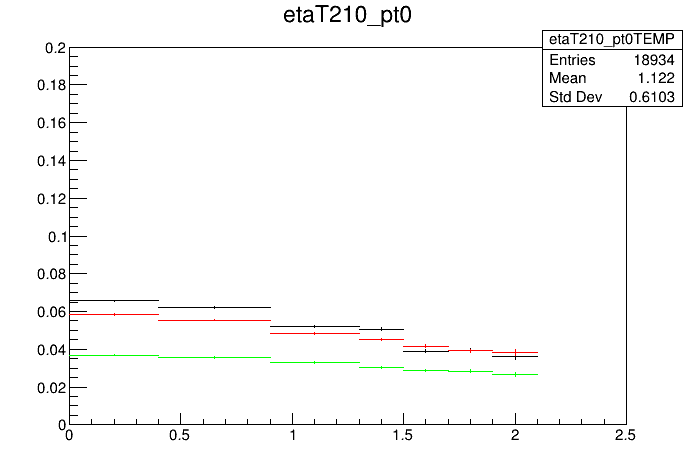

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

RateHists=OrderedDict([])
canvrate=TCanvas("canvrate","canvrate",700,500)
color=1

print("LHists",LHists)
for RH in LHists:
    
    RateHists["Rate"+RH]=copy.deepcopy(THists[RH])
    RateHists["Rate"+RH].Divide(RateHists["Rate"+RH],LHists[RH])

    RateHists["RateL"+RH]=copy.deepcopy(LTHists[RH])
    RateHists["RateL"+RH].Divide(RateHists["RateL"+RH],LHists[RH])

    RateHists["Rate"+RH].SetLineColor(color)
    RateHists["Rate"+RH].SetMarkerColor(color)
    RateHists["Rate"+RH].SetMaximum(0.2)
    RateHists["Rate"+RH].Draw("same")
    color+=1
    
RateHistsFULL=OrderedDict([])
for RH in LHistsFULL:
 
    RateHistsFULL["Rate"+RH]=copy.deepcopy(THistsFULL[RH])
    RateHistsFULL["Rate"+RH].Divide(RateHistsFULL["Rate"+RH],LHistsFULL[RH])

    RateHistsFULL["RateL"+RH]=copy.deepcopy(LTHistsFULL[RH])
    RateHistsFULL["RateL"+RH].Divide(RateHistsFULL["RateL"+RH],LHistsFULL[RH])

canvrate.Draw()
canvrate.Print('plots/Trate.png', 'png')


evcont["RateHists"]=RateHists
evcont["RateHistsFULL"]=RateHistsFULL

In [19]:
#Step1:use pass-to-fail ratio to predict background
proc = MakeProc(njet,1,evcont)
Mproc=PProcRunner(proc,nproc)
returndf=Mproc.Run()

len(hpass) 128


Dataset:QCD_HT1000to1500 Process:4:   0%|          | 0/6 [00:00<?, ?it/s]

Running process over 6 processors


Dataset:QCD_HT2000toInf Process:2: 100%|██████████| 4/4 [01:48<00:00, 27.05s/it]


Done
Done
Total time 404.5997302532196


In [20]:
histos=copy.deepcopy(proc.hists)

htosum={}
htosum["QCD"]=["QCD_HT1500to2000","QCD_HT1000to1500","QCD_HT2000toInf"]

histdicts=[histos,ratehistos]
for hdict in histdicts:
        for curh in htosum:
            hdict[curh]={}
            for var in hdict[htosum[curh][0]]:
                for curhsum in htosum[curh]:
                        if  var in hdict[curh]:
                                hdict[curh][var].Add(hdict[curhsum][var])
                        else:
                                hdict[curh][var] = copy.deepcopy(hdict[curhsum][var])
                                hdict[curh][var].SetName(hdict[curhsum][var].GetName().replace(curhsum,curh))
                                hdict[curh][var].SetTitle(hdict[curhsum][var].GetName().replace(curhsum,curh))

In [21]:
#Plot ht
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

output = TFile("FromFlatPandas_AE"+op_aeval+"_M"+op_massrange+"_Njet"+str(op_njet)+"_ntoys"+str(ntoys)+".root","recreate")
output.cd()

for RHtext in RateHists:
    RateHists[RHtext].Write("T"+RHtext)

for RHtext in RateHistsFULL:
    RateHistsFULL[RHtext].Write("T"+RHtext)

for ds in ratehistos:
    for var in ratehistos[ds]:
            print(ds,var,ratehistos[ds][var].Integral())
            ratehistos[ds][var].Write(ds+"__"+var)

for ds in histos:
    for var in histos[ds]:
        histos[ds][var].Write(ds+"__"+var)
        print(ds,var,histos[ds][var].Integral())

output.Close()

QCD_HT1000to1500 logMSE_all 308603841.0853882
QCD_HT1000to1500 ht_LT03 240.38833618164062
QCD_HT1000to1500 pt0_LT03 240.38833618164062
QCD_HT1000to1500 abseta0_LT03 240.38833618164062
QCD_HT1000to1500 pt1_LT03 240.38833618164062
QCD_HT1000to1500 abseta1_LT03 240.38833618164062
QCD_HT1000to1500 pt2_LT03 240.38833618164062
QCD_HT1000to1500 abseta2_LT03 240.38833618164062
QCD_HT1000to1500 etaL0_pt0 0.0
QCD_HT1000to1500 etaT0_pt0 0.0
QCD_HT1000to1500 etaL300_pt0 0.0
QCD_HT1000to1500 etaT210_pt0 0.0
QCD_HT1000to1500 etaL210_pt0 0.0
QCD_HT1000to1500 etaL0_pt1 0.0
QCD_HT1000to1500 etaT0_pt1 0.0
QCD_HT1000to1500 etaL300_pt1 0.0
QCD_HT1000to1500 etaT210_pt1 0.0
QCD_HT1000to1500 etaL210_pt1 0.0
QCD_HT1000to1500 etaL0_pt2 0.0
QCD_HT1000to1500 etaT0_pt2 0.0
QCD_HT1000to1500 etaL300_pt2 0.0
QCD_HT1000to1500 etaT210_pt2 0.0
QCD_HT1000to1500 etaL210_pt2 0.0
QCD_HT1000to1500 etaL0_pt3 0.0
QCD_HT1000to1500 etaT0_pt3 0.0
QCD_HT1000to1500 etaL300_pt3 0.0
QCD_HT1000to1500 etaT210_pt3 0.0
QCD_HT1000to1500 

QCD_HT1000to1500 etaL2_pt11 73537.00354003906
QCD_HT1000to1500 etaT2_pt11 3441.9239044189453
QCD_HT1000to1500 etaL302_pt11 65724.37518310547
QCD_HT1000to1500 etaT212_pt11 3135.975112915039
QCD_HT1000to1500 etaL212_pt11 7659.646591186523
QCD_HT1000to1500 etaL2_pt12 35544.69418334961
QCD_HT1000to1500 etaT2_pt12 1464.1835021972656
QCD_HT1000to1500 etaL302_pt12 31676.626708984375
QCD_HT1000to1500 etaT212_pt12 1234.721908569336
QCD_HT1000to1500 etaL212_pt12 3802.5064086914062
QCD_HT1000to1500 etaL2_pt13 15439.487213134766
QCD_HT1000to1500 etaT2_pt13 775.7987213134766
QCD_HT1000to1500 etaL302_pt13 13614.721206665039
QCD_HT1000to1500 etaT212_pt13 655.6045532226562
QCD_HT1000to1500 etaL212_pt13 1791.9857788085938
QCD_HT1000to1500 etaL2_pt14 5583.565444946289
QCD_HT1000to1500 etaT2_pt14 251.31507873535156
QCD_HT1000to1500 etaL302_pt14 4807.7667236328125
QCD_HT1000to1500 etaT212_pt14 240.38833618164062
QCD_HT1000to1500 etaL212_pt14 753.9452362060547
QCD_HT1000to1500 etaL2_pt15 2141.6415405273438

QCD_HT1000to1500 etaT213_pt36 0.0
QCD_HT1000to1500 etaL213_pt36 0.0
QCD_HT1000to1500 etaL3_pt37 0.0
QCD_HT1000to1500 etaT3_pt37 0.0
QCD_HT1000to1500 etaL303_pt37 0.0
QCD_HT1000to1500 etaT213_pt37 0.0
QCD_HT1000to1500 etaL213_pt37 0.0
QCD_HT1000to1500 etaL3_pt38 0.0
QCD_HT1000to1500 etaT3_pt38 0.0
QCD_HT1000to1500 etaL303_pt38 0.0
QCD_HT1000to1500 etaT213_pt38 0.0
QCD_HT1000to1500 etaL213_pt38 0.0
QCD_HT1000to1500 etaL3_pt39 0.0
QCD_HT1000to1500 etaT3_pt39 0.0
QCD_HT1000to1500 etaL303_pt39 0.0
QCD_HT1000to1500 etaT213_pt39 0.0
QCD_HT1000to1500 etaL213_pt39 0.0
QCD_HT1500to2000 logMSE_all 30741532.885497212
QCD_HT1500to2000 ht_LT03 144.6606684923172
QCD_HT1500to2000 pt0_LT03 144.6606683731079
QCD_HT1500to2000 abseta0_LT03 144.6606686115265
QCD_HT1500to2000 pt1_LT03 144.6606684923172
QCD_HT1500to2000 abseta1_LT03 144.6606683731079
QCD_HT1500to2000 pt2_LT03 144.66066801548004
QCD_HT1500to2000 abseta2_LT03 144.6606684923172
QCD_HT1500to2000 etaL0_pt0 0.0
QCD_HT1500to2000 etaT0_pt0 0.0
QCD_H

QCD_HT1500to2000 etaT212_pt1 5465.544078826904
QCD_HT1500to2000 etaL212_pt1 26249.316772460938
QCD_HT1500to2000 etaL2_pt2 242372.77490234375
QCD_HT1500to2000 etaT2_pt2 6271.698974609375
QCD_HT1500to2000 etaL302_pt2 217557.13989257812
QCD_HT1500to2000 etaT212_pt2 5666.754020690918
QCD_HT1500to2000 etaL212_pt2 24283.2509765625
QCD_HT1500to2000 etaL2_pt3 228573.5673828125
QCD_HT1500to2000 etaT2_pt3 6365.070892333984
QCD_HT1500to2000 etaL302_pt3 205112.40576171875
QCD_HT1500to2000 etaT212_pt3 5725.93350982666
QCD_HT1500to2000 etaL212_pt3 22995.77313232422
QCD_HT1500to2000 etaL2_pt4 219983.43188476562
QCD_HT1500to2000 etaT2_pt4 6313.782157897949
QCD_HT1500to2000 etaL302_pt4 198102.97729492188
QCD_HT1500to2000 etaT212_pt4 5704.891944885254
QCD_HT1500to2000 etaL212_pt4 21459.742431640625
QCD_HT1500to2000 etaL2_pt5 212775.39526367188
QCD_HT1500to2000 etaT2_pt5 6514.992095947266
QCD_HT1500to2000 etaL302_pt5 191476.18334960938
QCD_HT1500to2000 etaT212_pt5 5877.169692993164
QCD_HT1500to2000 etaL2

QCD_HT2000toInf etaL211_pt9 34.05856519937515
QCD_HT2000toInf etaL1_pt10 512.5814051628113
QCD_HT2000toInf etaT1_pt10 19.86749631166458
QCD_HT2000toInf etaL301_pt10 456.38477087020874
QCD_HT2000toInf etaT211_pt10 18.73221081495285
QCD_HT2000toInf etaL211_pt10 55.628989458084106
QCD_HT2000toInf etaL1_pt11 796.9704179763794
QCD_HT2000toInf etaT1_pt11 25.54392385482788
QCD_HT2000toInf etaL301_pt11 724.8797831535339
QCD_HT2000toInf etaT211_pt11 23.84099566936493
QCD_HT2000toInf etaL211_pt11 72.09062975645065
QCD_HT2000toInf etaL1_pt12 1179.561658859253
QCD_HT2000toInf etaT1_pt12 44.276134967803955
QCD_HT2000toInf etaL301_pt12 1077.9536085128784
QCD_HT2000toInf etaT211_pt12 41.43792128562927
QCD_HT2000toInf etaL211_pt12 98.76983904838562
QCD_HT2000toInf etaL1_pt13 1887.9799575805664
QCD_HT2000toInf etaT1_pt13 70.38770067691803
QCD_HT2000toInf etaL301_pt13 1718.822401046753
QCD_HT2000toInf etaT211_pt13 65.84655904769897
QCD_HT2000toInf etaL211_pt13 165.75168335437775
QCD_HT2000toInf etaL1_pt

QCD etaL210_pt15 15688.177215576172
QCD etaL0_pt16 319462.29931640625
QCD etaT0_pt16 15315.680587768555
QCD etaL300_pt16 295710.62158203125
QCD etaT210_pt16 14498.610885620117
QCD etaL210_pt16 23432.051177978516
QCD etaL0_pt17 413550.8400878906
QCD etaT0_pt17 20448.334259033203
QCD etaL300_pt17 382518.90087890625
QCD etaT210_pt17 19312.247833251953
QCD etaL210_pt17 30547.090240478516
QCD etaL0_pt18 491410.22119140625
QCD etaT0_pt18 25342.499710083008
QCD etaL300_pt18 456909.0158691406
QCD etaT210_pt18 24103.84994506836
QCD etaL210_pt18 33994.682678222656
QCD etaL0_pt19 542167.4360351562
QCD etaT0_pt19 28180.342849731445
QCD etaL300_pt19 501933.01611328125
QCD etaT210_pt19 26574.764587402344
QCD etaL210_pt19 39521.28927612305
QCD etaL0_pt20 572648.150390625
QCD etaT0_pt20 31567.371841430664
QCD etaL300_pt20 530483.6040039062
QCD etaT210_pt20 30042.876251220703
QCD etaL210_pt20 41646.65408325195
QCD etaL0_pt21 572107.3198242188
QCD etaT0_pt21 30896.322311401367
QCD etaL300_pt21 529854.08

QCD etaT3_pt30 0.0
QCD etaL303_pt30 0.0
QCD etaT213_pt30 0.0
QCD etaL213_pt30 0.0
QCD etaL3_pt31 0.0
QCD etaT3_pt31 0.0
QCD etaL303_pt31 0.0
QCD etaT213_pt31 0.0
QCD etaL213_pt31 0.0
QCD etaL3_pt32 0.0
QCD etaT3_pt32 0.0
QCD etaL303_pt32 0.0
QCD etaT213_pt32 0.0
QCD etaL213_pt32 0.0
QCD etaL3_pt33 0.0
QCD etaT3_pt33 0.0
QCD etaL303_pt33 0.0
QCD etaT213_pt33 0.0
QCD etaL213_pt33 0.0
QCD etaL3_pt34 0.0
QCD etaT3_pt34 0.0
QCD etaL303_pt34 0.0
QCD etaT213_pt34 0.0
QCD etaL213_pt34 0.0
QCD etaL3_pt35 0.0
QCD etaT3_pt35 0.0
QCD etaL303_pt35 0.0
QCD etaT213_pt35 0.0
QCD etaL213_pt35 0.0
QCD etaL3_pt36 0.0
QCD etaT3_pt36 0.0
QCD etaL303_pt36 0.0
QCD etaT213_pt36 0.0
QCD etaL213_pt36 0.0
QCD etaL3_pt37 0.0
QCD etaT3_pt37 0.0
QCD etaL303_pt37 0.0
QCD etaT213_pt37 0.0
QCD etaL213_pt37 0.0
QCD etaL3_pt38 0.0
QCD etaT3_pt38 0.0
QCD etaL303_pt38 0.0
QCD etaT213_pt38 0.0
QCD etaL213_pt38 0.0
QCD etaL3_pt39 0.0
QCD etaT3_pt39 0.0
QCD etaL303_pt39 0.0
QCD etaT213_pt39 0.0
QCD etaL213_pt39 0.0
QCD_HT100

QCD bkg_pt0_LT30 988892.3530883491
QCD bkg_ptUP0_LT30 1024671.6895450354
QCD bkg_ptDOWN0_LT30 953122.9103090614
QCD bkg_abseta0_LT30 988896.732421875
QCD bkg_pt1_LT30 988898.3648889214
QCD bkg_ptUP1_LT30 1028125.6895829588
QCD bkg_ptDOWN1_LT30 949678.6122233719
QCD bkg_abseta1_LT30 988900.8583984375
QCD bkg_pt2_LT30 988894.4206615686
QCD bkg_ptUP2_LT30 1022119.1487335563
QCD bkg_ptDOWN2_LT30 955672.276487574
QCD bkg_abseta2_LT30 988894.5517578125


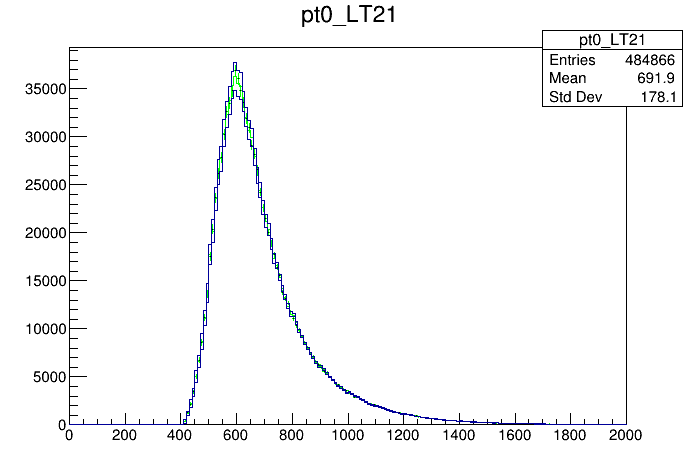

In [22]:
ptcanv=TCanvas("pt0","pt0",700,500)
ratehistos["QCD"]["pt0_LT21"].SetLineColor(3)
histos["QCD"]["bkg_pt0_LT21"].SetLineColor(3)
ratehistos["QCD"]["pt0_LT21"].GetXaxis().SetRangeUser(0,2000)
ratehistos["QCD"]["pt0_LT21"].Draw()
histos["QCD"]["bkg_pt0_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptUP0_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptDOWN0_LT21"].Draw("histsame")
ptcanv.Draw()

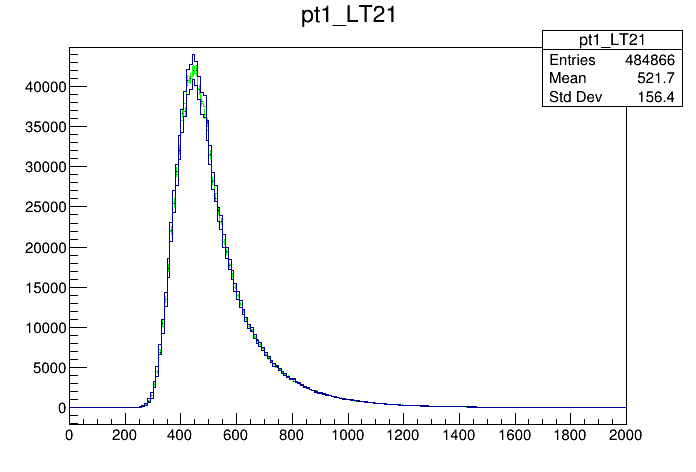

In [23]:
ptcanv=TCanvas("pt1","pt1",700,500)
ratehistos["QCD"]["pt1_LT21"].SetLineColor(3)
histos["QCD"]["bkg_pt1_LT21"].SetLineColor(3)

ratehistos["QCD"]["pt1_LT21"].GetXaxis().SetRangeUser(0,2000)
ratehistos["QCD"]["pt1_LT21"].Draw()
histos["QCD"]["bkg_pt1_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptUP1_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptDOWN1_LT21"].Draw("histsame")
ptcanv.Draw()

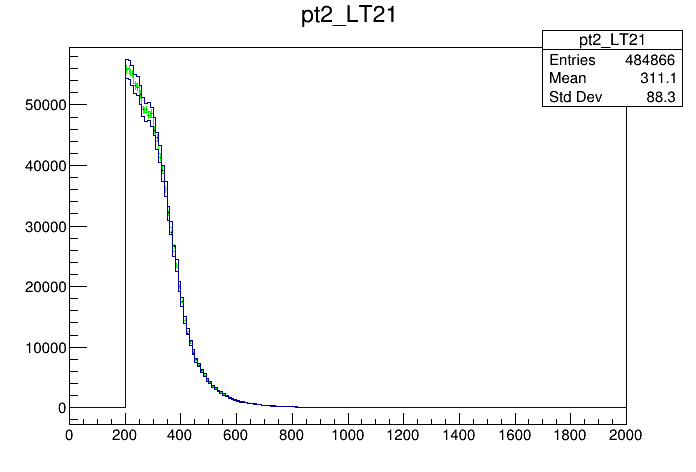

In [24]:
ptcanv=TCanvas("pt2","pt2",700,500)
ratehistos["QCD"]["pt2_LT21"].SetLineColor(3)
histos["QCD"]["bkg_pt2_LT21"].SetLineColor(3)

ratehistos["QCD"]["pt2_LT21"].GetXaxis().SetRangeUser(0,2000)
ratehistos["QCD"]["pt2_LT21"].Draw()
histos["QCD"]["bkg_pt2_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptUP2_LT21"].Draw("histsame")
histos["QCD"]["bkg_ptDOWN2_LT21"].Draw("histsame")
ptcanv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      267.547
NDf                       =          118
p0                        =     0.840784   +/-   0.00779414  
p1                        =  0.000115055   +/-   4.0327e-06  


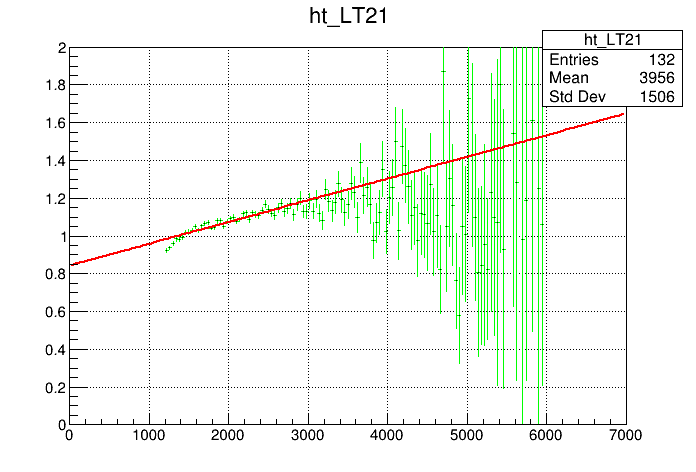

In [25]:
tempQCDht = ratehistos["QCD"]["ht_LT21"]
tempQCDhtbkg = histos["QCD"]["bkg_ht_LT21"]
ht_LT21ratio = tempQCDht.Rebin(4) / tempQCDhtbkg.Rebin(4)

htcanv=TCanvas("ht","ht",700,500)
ht_LT21ratio.SetLineColor(3)
ht_LT21ratio.SetMinimum(0)
ht_LT21ratio.SetMaximum(2)
ht_LT21ratio.Draw("")
ht_LT21ratio.Fit("pol1")
htcanv.SetGrid()
htcanv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      47.6236
NDf                       =           68
p0                        =     0.997875   +/-   0.00706243  
p1                        =   3.5661e-06   +/-   7.55223e-06 


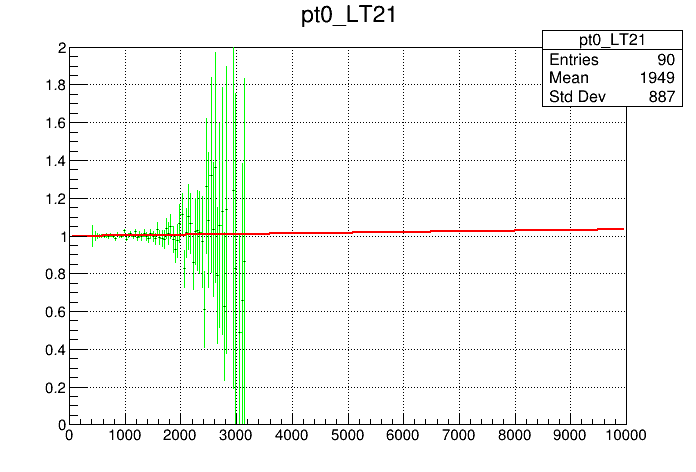

In [26]:
tempQCDpt = ratehistos["QCD"]["pt0_LT21"]
tempQCDptbkg = histos["QCD"]["bkg_pt0_LT21"]
pt_LT21ratio = tempQCDpt.Rebin(4) / tempQCDptbkg.Rebin(4)

ptcanv=TCanvas("pt","pt",700,500)
pt_LT21ratio.SetLineColor(3)
pt_LT21ratio.SetMinimum(0)
pt_LT21ratio.SetMaximum(2)
pt_LT21ratio.Draw("")
pt_LT21ratio.Fit("pol1")
ptcanv.SetGrid()
ptcanv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      42.0325
NDf                       =           61
p0                        =     0.998191   +/-   0.00631646  
p1                        =  2.90672e-06   +/-   8.55239e-06 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: pt


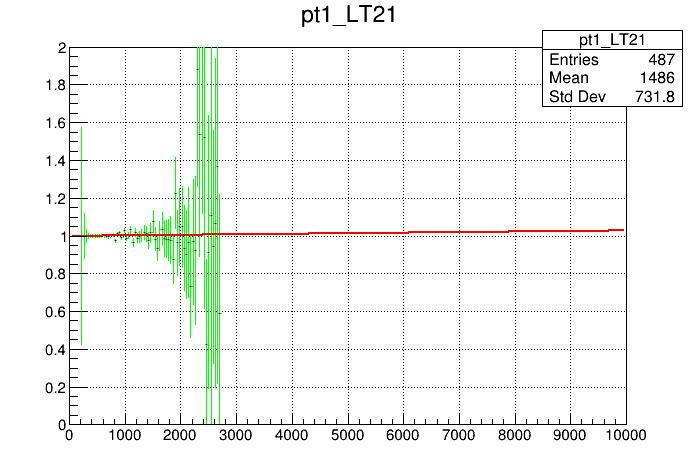

In [27]:
tempQCDpt = ratehistos["QCD"]["pt1_LT21"]
tempQCDptbkg = histos["QCD"]["bkg_pt1_LT21"]
pt_LT21ratio = tempQCDpt.Rebin(4) / tempQCDptbkg.Rebin(4)

ptcanv=TCanvas("pt","pt",700,500)
pt_LT21ratio.SetLineColor(3)
pt_LT21ratio.SetMinimum(0)
pt_LT21ratio.SetMaximum(2)
pt_LT21ratio.Draw("")
pt_LT21ratio.Fit("pol1")
ptcanv.SetGrid()
ptcanv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      17.0411
NDf                       =           30
p0                        =      1.00095   +/-   0.0068976   
p1                        = -2.72452e-06   +/-   1.6711e-05  


Warning in <TCanvas::Constructor>: Deleting canvas with same name: pt


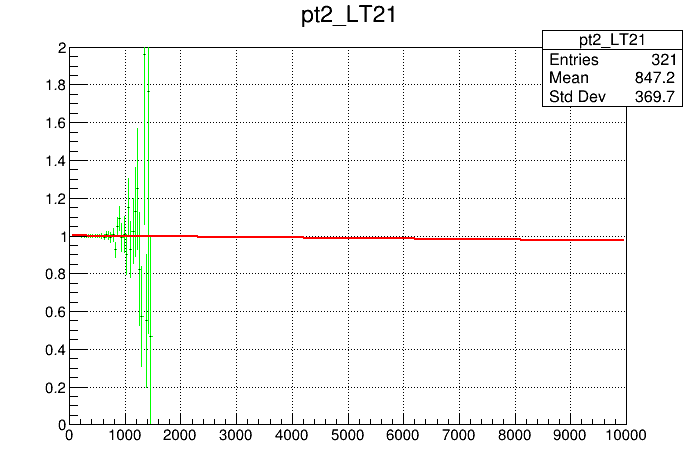

In [28]:
tempQCDpt = ratehistos["QCD"]["pt2_LT21"]
tempQCDptbkg = histos["QCD"]["bkg_pt2_LT21"]
pt_LT21ratio = tempQCDpt.Rebin(4) / tempQCDptbkg.Rebin(4)

ptcanv=TCanvas("pt","pt",700,500)
pt_LT21ratio.SetLineColor(3)
pt_LT21ratio.SetMinimum(0)
pt_LT21ratio.SetMaximum(2)
pt_LT21ratio.Draw("")
pt_LT21ratio.Fit("pol1")
ptcanv.SetGrid()
ptcanv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      21.1239
NDf                       =            8
p0                        =      1.00222   +/-   0.00500625  
p1                        =  -0.00314587   +/-   0.00561081  


Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.
Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.


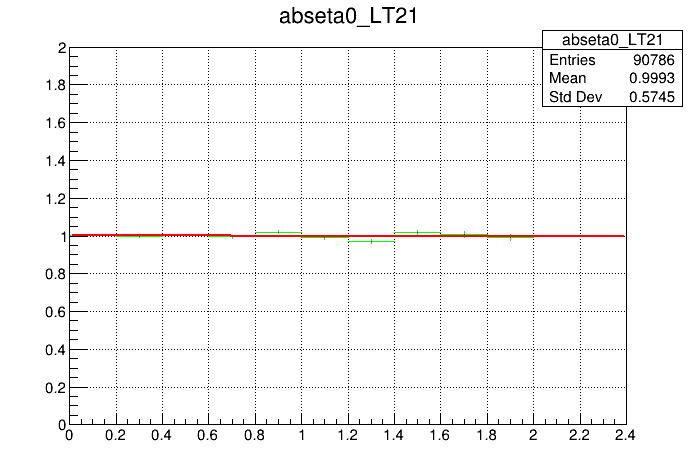

In [29]:
tempQCDabseta0 = ratehistos["QCD"]["abseta0_LT21"]
tempQCDabseta0bkg = histos["QCD"]["bkg_abseta0_LT21"]
abseta0_LT21ratio = tempQCDabseta0.Rebin(4) / tempQCDabseta0bkg.Rebin(4)

abseta0canv=TCanvas("abseta0","abseta0",700,500)
abseta0_LT21ratio.SetLineColor(3)
abseta0_LT21ratio.SetMinimum(0)
abseta0_LT21ratio.SetMaximum(2)
abseta0_LT21ratio.Draw("")
abseta0_LT21ratio.Fit("pol1")
abseta0canv.SetGrid()
abseta0canv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      11.1782
NDf                       =            8
p0                        =     0.999683   +/-   0.00507253  
p1                        =  0.000279506   +/-   0.00524549  


Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.
Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.


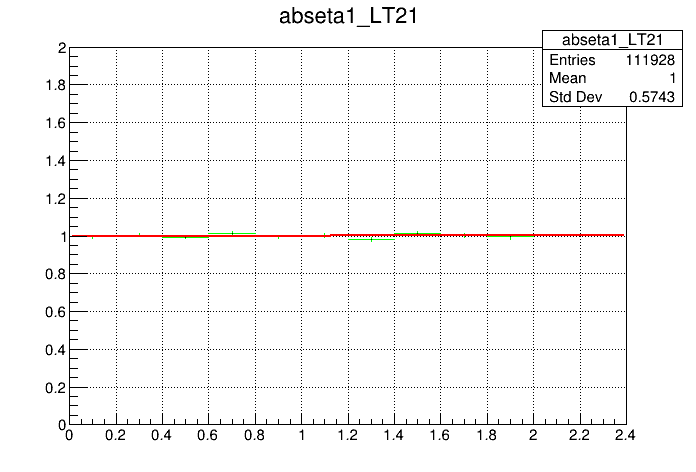

In [30]:
tempQCDabseta1 = ratehistos["QCD"]["abseta1_LT21"]
tempQCDabseta1bkg = histos["QCD"]["bkg_abseta1_LT21"]
abseta1_LT21ratio = tempQCDabseta1.Rebin(4) / tempQCDabseta1bkg.Rebin(4)

abseta1canv=TCanvas("abseta1","abseta1",700,500)
abseta1_LT21ratio.SetLineColor(3)
abseta1_LT21ratio.SetMinimum(0)
abseta1_LT21ratio.SetMaximum(2)
abseta1_LT21ratio.Draw("")
abseta1_LT21ratio.Fit("pol1")
abseta1canv.SetGrid()
abseta1canv.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      3.33436
NDf                       =            8
p0                        =     0.998129   +/-   0.00521802  
p1                        =   0.00209032   +/-   0.00507108  


Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.
Warning in <TH1F::Rebin>: ngroup=4 is not an exact divider of nbins=50.


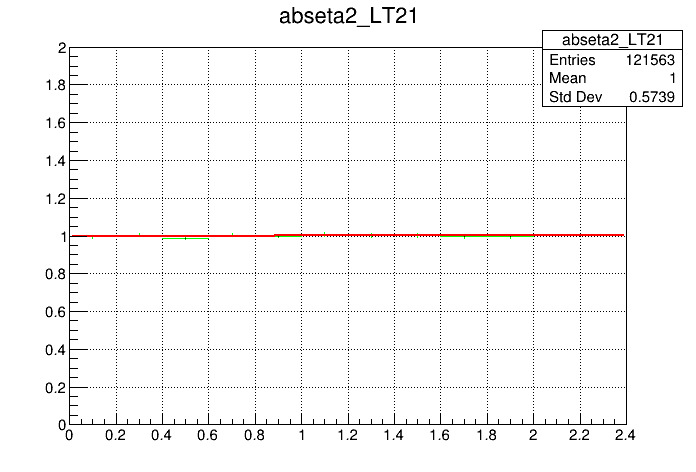

In [31]:
tempQCDabseta2 = ratehistos["QCD"]["abseta2_LT21"]
tempQCDabseta2bkg = histos["QCD"]["bkg_abseta2_LT21"]
abseta2_LT21ratio = tempQCDabseta2.Rebin(4) / tempQCDabseta2bkg.Rebin(4)

abseta2canv=TCanvas("abseta2","abseta2",700,500)
abseta2_LT21ratio.SetLineColor(3)
abseta2_LT21ratio.SetMinimum(0)
abseta2_LT21ratio.SetMaximum(2)
abseta2_LT21ratio.Draw("")
abseta2_LT21ratio.Fit("pol1")
abseta2canv.SetGrid()
abseta2canv.Draw()